Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "VINCENT ROEST GAWAN DEKKER"

---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---
## 1. Policy Evaluation (1 point)

In this exercise we will evaluate a policy, e.g. find the value function for a policy. The problem we consider is the gridworld from Example 4.1 in the book. The environment is implemented as `GridworldEnv`, which is a subclass of the `Env` class from [OpenAI Gym](https://github.com/openai/gym). This means that we can interact with the environment. We can look at the documentation to see how we can interact with the environment.

In [3]:
from gridworld import GridworldEnv
env = GridworldEnv()
# Lets see what this is
?env

In [4]:
# To have a quick look into the code
??env

Now we want to evaluate a policy by using Dynamic Programming. For more information, see the [Intro to RL](https://drive.google.com/open?id=1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG) book, section 4.1. This algorithm requires knowledge of the problem dynamics in the form of the transition probabilities $p(s',r|s,a)$. In general these are not available, but for our gridworld we know the dynamics and these can be accessed as `env.P`.

In [5]:
# Take a moment to figure out what P represents. 
# Note that this is a deterministic environment. 
# What would a stochastic environment look like?
env.P

{0: {0: [(1.0, 0, 0.0, True)],
  1: [(1.0, 0, 0.0, True)],
  2: [(1.0, 0, 0.0, True)],
  3: [(1.0, 0, 0.0, True)]},
 1: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 2, -1.0, False)],
  2: [(1.0, 5, -1.0, False)],
  3: [(1.0, 0, -1.0, True)]},
 2: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 6, -1.0, False)],
  3: [(1.0, 1, -1.0, False)]},
 3: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 3, -1.0, False)],
  2: [(1.0, 7, -1.0, False)],
  3: [(1.0, 2, -1.0, False)]},
 4: {0: [(1.0, 0, -1.0, True)],
  1: [(1.0, 5, -1.0, False)],
  2: [(1.0, 8, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 5: {0: [(1.0, 1, -1.0, False)],
  1: [(1.0, 6, -1.0, False)],
  2: [(1.0, 9, -1.0, False)],
  3: [(1.0, 4, -1.0, False)]},
 6: {0: [(1.0, 2, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 10, -1.0, False)],
  3: [(1.0, 5, -1.0, False)]},
 7: {0: [(1.0, 3, -1.0, False)],
  1: [(1.0, 7, -1.0, False)],
  2: [(1.0, 11, -1.0, False)],
  3: [(1.0, 6, -1.0, False)]},
 8: {0: [(1.0, 4

In [6]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change (delta_value) is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta_value = 0
        # evaluate all states
        for state in range(env.nS):
            value = 0
            for action, action_probability in enumerate(policy[state]):
                # check all actions for next state
                for prob, next_state, reward, done in env.P[state][action]:
                    value += action_probability * prob * (reward + discount_factor * V[next_state])

            delta_value = max(delta_value, np.abs(value - V[state]))
            V[state] = value
        
        if delta_value < theta:
            break;
            
    return np.array(V)

In [7]:
# Let's run your code, does it make sense?
random_policy = np.ones([env.nS, env.nA]) / env.nA
V = policy_eval(random_policy, env)
V

array([  0.        , -13.99993529, -19.99990698, -21.99989761,
       -13.99993529, -17.9999206 , -19.99991379, -19.99991477,
       -19.99990698, -19.99991379, -17.99992725, -13.99994569,
       -21.99989761, -19.99991477, -13.99994569,   0.        ])

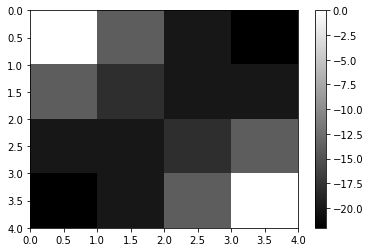

In [8]:
def plot_gridworld_value(V):
    plt.figure()
    c = plt.pcolormesh(V, cmap='gray')
    plt.colorbar(c)
    plt.gca().invert_yaxis()  # In the array, first row = 0 is on top

# Making a plot always helps
plot_gridworld_value(V.reshape(env.shape))

In [9]:
# Test: When you hand in the nodebook we will check that the value function is (approximately) what we expected
# but we need to make sure it is at least of the correct shape
v = policy_eval(random_policy, env)
assert v.shape == (env.nS)

---
## 2. Policy Iteration (2 points)
Using the policy evaluation algorithm we can implement policy iteration to find a good policy for this problem. Note that we do not need to use a discount_factor for episodic tasks but make sure your implementation can handle this correctly!

In [10]:
def policy_improvement(env, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        V = policy_eval(policy, env, discount_factor)
        # flag when the actions are no longer updated
        flag = True
        for state in range(env.nS):
            # sutton 2.2
            policy_action = np.argmax(policy[state])
            
            # empty action values for this state and policy
            # copied from above, minus the action_probability
            action_values = np.zeros(len(policy[state]))
            for action in range(len(policy[state])):
                for prob, next_state, reward, done in env.P[state][action]:
                    action_values[action] = prob * (reward + discount_factor * V[next_state])

            # Ties? p. 62 sutton -> just pick one arbitrarily
            best_action = np.argmax(action_values)
            
            # was the action selected actually the greedy?
            if (best_action != policy_action):
                flag = False
                
            # update the policy with a 1 in the position of the best action
            # one hot encoding -> get a 4d (#actions) diagonal and pick the 
            # one for the action taken
            policy[state] = np.eye(len(policy[state]))[best_action]
                
        if (flag):
            break
    
    return policy, V

Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



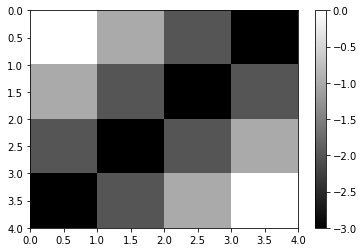

In [11]:
# Let's see what it does
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

def print_grid_policy(policy, symbols=["^", ">", "v", "<"]):
    symbols = np.array(symbols)
    for row in policy:
        print("".join(symbols[row]))

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")

plot_gridworld_value(v.reshape(env.shape))

In [12]:
# This is not an empty cell. It is needed for grading.

---
## 3. Value Iteration (3 points)
Now implement the value iteration algorithm.

In [13]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    

    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA])
    
    while True:
        delta_v = 0
        for state in range(env.nS):
            # get best action
            action_values = np.zeros(env.nA)
            for action in range(len(policy[state])):
                    for prob, next_state, reward, done in env.P[state][action]:
                        action_values[action] = prob * (reward + discount_factor * V[next_state])
            # note not argmax, but max
            best_action = np.max(action_values)
            # get the delta to see if we can stop
            delta_v = max(delta_v, np.abs(best_action - V[state]))
            # set the value 
            V[state] = best_action
            
        if (delta_v < theta):
            break;

    # this is the policy
    for state in range(env.nS):
        action_values = np.zeros(env.nA)
        for action in range(len(policy[state])):
                for prob, next_state, reward, done in env.P[state][action]:
                    action_values[action] = prob * (reward + discount_factor * V[next_state])
        # here we need the index again instead of the value
        # so use argmax
        best_action = np.argmax(action_values)
        # Always take the best action
        policy[state, best_action] = 1
    
    return policy, V

In [14]:
# Oh let's test again
# Let's see what it does
policy, v = value_iteration(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print_grid_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")


Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]
^<<v
^^^v
^^>v
^>>^

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



What is the difference between value iteration and policy iteration? Which algorithm is most efficient (e.g. needs to perform the least *backup* operations)? Please answer *concisely* in the cell below.

`
Policy iteration first updates the value function to the fullest extend and then does the same to the policy. Then these two steps get repeated untill the policy does not change anymore.
`

`
For value iteration, we only need to evaluate the value function (based on maximum) and policy once instead of going back and forth.
`

`
Value iteration is more efficient because policy evaluation is stopped after just one sweep (one update of each state) - from sutton p. 65, instead of the multiple evaluations for policy iterations.
`

## 4. Monte Carlo Prediction (7 points)
What is the difference between Dynamic Programming and Monte Carlo? When would you use the one or the other algorithm?

`
Dynamic Programming methods require complete knowledge about the environment and determines a policy based on that information. Monte Carlo methods don't require complete knowledge, but work from their experience in interacting with the environment instead.
`

`
Monte Carlo is very useful if you don't have a complete knowledge of the environment. If you do have such knowledge, Dynamic Programming methods become more attractive.
`

For the Monte Carlo Prediction we will look at the Blackjack game (Example 5.1 from the book), for which the `BlackjackEnv` is implemented in `blackjack.py`. Note that compared to the gridworld, the state is no longer a single integer, which is why we use a dictionary to represent the value function instead of a numpy array. By using `defaultdict`, each state gets a default value of 0.

In [15]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

For the Monte Carlo algorithm, we need to *interact* with the environment. This means that we start an episode by using `env.reset` and send the environment actions via `env.step` to observe the reward and next observation (state).

In [16]:
# So let's have a look at what we can do in general with an environment...
import gym
?gym.Env

In [17]:
# We can also look at the documentation/implementation of a method
?env.step

In [18]:
??BlackjackEnv

A very simple policy for Blackjack is to *stick* if we have 20 or 21 points and *hit* otherwise. We want to know how good this policy is. This policy is *deterministic* and therefore a function that maps an observation to a single action. Technically, we can implement this as a dictionary or as a function, where we use the latter. To get started, let's implement this simple policy for BlackJack.

In [19]:
def simple_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, _, _ = observation
    # 0 is stick, 1 is hit
    return 0 if score >= 20 else 1

In [20]:
s = env.reset()
print(s)
a = simple_policy(s)
print(env.step(a))

(13, 1, False)
((14, 1, False), 0, False, {})


Now implement either the MC prediction algorithm (either first visit or every visit). Hint: you can use `for i in tqdm(range(num_episodes))` to show a progress bar.

In [21]:
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        T: number of steps in episode
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
        # generate a single episode which is gonna be (state, action, reward)
        episode = []
        # don't forget this
        state = env.reset()
        for _ in range(100):
            a = policy(state)
            next_state, reward, done, info = env.step(a)
            episode.append((state, a, reward))
            if done:
                break;
            # continue until bust / stick
            state = next_state

        # helper to map a state to a unique id
        def state_to_id(state):
            # this is not so handy when plotting, apparently defaultdict handles tuples as keys
            # return str(state[0][0]) + '-' + str(state[0][1]) + '-'+ str(state[0][2])
            return tuple(state[0])
        
        # find all unique states in this episode
        states_in_episode = set([state_to_id(x) for x in episode])        
    
        for state in states_in_episode:
            # print (state)
            # we find where this state occured in this episode
            idx_of_state = [state_to_id(x) for x in episode].index(state)            
            G = 0
            for i, observation in enumerate(episode[idx_of_state:]):
                _, _, reward = observation
                G += reward*(discount_factor**i)
                
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state] / returns_count[state]
            
            """ EVERY VISIT
            for s, a, r in episode[::-1]:
                G = G * discount_factor + r
                # no check -> every visit
                returns_sum[s] += G
                returns_count[s] += 1
    for s in returns_sum.keys():
        V[s] = returns_sum[s] / returns_count[s]
            """
    
    return V

In [22]:
V = mc_prediction(simple_policy, env, num_episodes=1000)
# best values you can have (cause you won with 21 and odds for dealer to get 21 with 3, 4 open are low)
print (V[(21, 4, True)])
# some of the worst (17 is almost guarantee for bust):
print (V[(17, 10, False)])


100%|██████████| 1000/1000 [00:00<00:00, 12492.16it/s]

1.0
-0.5681818181818182


Now make *4 plots* like Figure 5.1 in the book. You can either make 3D plots or heatmaps. Make sure that your results look similar to the results in the book. Give your plots appropriate titles, axis labels, etc.

In [23]:
%%time
# Let's run your code one time
V_10k = mc_prediction(simple_policy, env, num_episodes=10000)
V_500k = mc_prediction(simple_policy, env, num_episodes=500000)

100%|██████████| 500000/500000 [00:30<00:00, 16328.03it/s]

CPU times: user 31.3 s, sys: 16 ms, total: 31.3 s
Wall time: 31.3 s


Text(0.5, 0.92, 'Value function - 500K episodes - Aces')

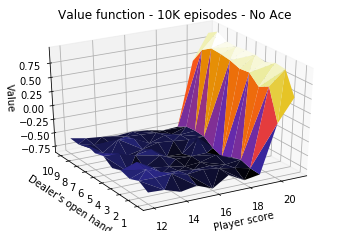

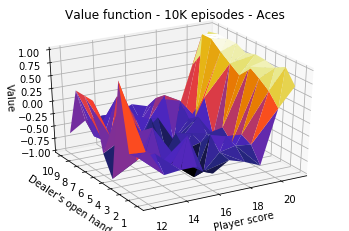

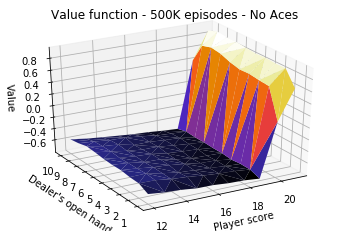

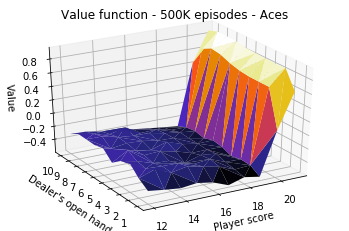

In [24]:
from mpl_toolkits.mplot3d import Axes3D

def plot_value_function(V, aces=True):
    # x axis we have the player values
    x = [value[0][0] for value in V.items() if value[0][2] == aces]
    # y axis we have dealer values
    y = [value[0][1] for value in V.items() if value[0][2] == aces]
    # z axis we do the value
    z = [value[1] for value in V.items() if value[0][2] == aces]

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    plt.xlabel('Player score')
    plt.ylabel('Dealer\'s open hand')
    ax.set_zlabel('Value')
    ax.set_yticks(range(1, 11))
    ax.plot_trisurf(x, y, z, cmap=plt.cm.CMRmap, linewidth=0.2,)
    ax.view_init(azim=-120)
    return ax

plot_value_function(V_10k, False)
plt.title('Value function - 10K episodes - No Ace')


plot_value_function(V_10k, True)
plt.title('Value function - 10K episodes - Aces')


plot_value_function(V_500k, False )
plt.title('Value function - 500K episodes - No Aces')


plot_value_function(V_500k, True)
plt.title('Value function - 500K episodes - Aces')
    

## 5. Monte Carlo control with $\epsilon$-greedy policy (5 points)
Now we have a method to evaluate state-values given a policy. Take a moment to think whether we can use the value function to find a better policy? Assuming we do not know the dynamics of the environment, why is this not possible?

We want a policy that selects _actions_ with maximum value, e.g. is _greedy_ with respect to the _action-value_ (or Q-value) function $Q(s,a)$. We need to keep exploring, so with probability $\epsilon$ we will take a random action. First, lets implement a function `make_epsilon_greedy_policy` that takes the Q-value function and returns an $\epsilon$-greedy policy. The policy itself is a function that returns an action.

In [25]:
import random 

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        an action according to the epsilon-greedy policy.
    
    """
    def policy_fn(observation):
        if np.random.rand() < epsilon:
            return np.random.choice(range(nA))
        else:
            return np.argmax(Q[observation])
        
        ''' Alternative version
        # PAGE 81 
        # for all ... part
        # init with only epsilons that have prob > 0
        A = np.array([epsilon / nA for i in range(nA)])
        # argmax here means that ties are resolved
        # by the first index
        best_action = np.argmax(Q[observation])
        A[best_action] += 1-epsilon
        assert sum(A) == 1, "probabilities do not sum to 1"
        return np.random.choice(np.arange(nA), p=A)
        '''
    
    return policy_fn


In [26]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Again, keep track of counts for efficiency
    # returns_sum, returns_count and Q are 
    # nested dictionaries that map state -> (action -> action-value).
    # We could also use tuples (s, a) as keys in a 1d dictionary, but this
    # way Q is in the format that works with make_epsilon_greedy_policy
    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, dtype=int))
    
    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # from the pseudocode in sutton p81
    # episode generation
    for _ in tqdm(range(num_episodes)):
        episode = []
        state = env.reset()
        # copied from previous function
        for _ in range(12):
            a = policy(state)
            next_state, reward, done, info = env.step(a)
            episode.append((state, a, reward))
            if done:
                break;
            # continue until bust / stick
            state = next_state
        
        
        # helper to map a state to a unique id
        def state_action_to_id(state_action):
            return (tuple(state_action[0]), state_action[1])
        
        # find all unique states in this episode
        episode_vals = set([state_action_to_id(x) for x in episode])
        for state, a in episode_vals:
            # FIRST VISIT
            idx_of_state = [state_action_to_id(x) for x in episode].index((state, a))            

            G = 0
            for i, observation in enumerate(episode[idx_of_state:]):
                _, _, reward = observation
                G += reward*(discount_factor**i)
            
            returns_sum[state][a] += G
            returns_count[state][a] += 1.0
            Q[state][a] = returns_sum[state][a] / returns_count[state][a]
            
        """EVERY VISIT
        G = 0
        for s, a, r in episode[::-1]:
            G = G * discount_factor + r
            # no check -> every visit
            returns_sum[s][a] += G
            returns_count[s][a] += 1
            Q[s][a] = returns_sum[s][a] / returns_count[s][a]
            
        """
        
        # The policy is improved implicitly by changing the Q dictionary
    return Q, policy

# Test it quickly
Q, policy = mc_control_epsilon_greedy(env, num_episodes=10000, epsilon=0.1)

100%|██████████| 10000/10000 [00:00<00:00, 10959.56it/s]


In [27]:
%%time
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

100%|██████████| 500000/500000 [00:43<00:00, 11469.11it/s]

CPU times: user 43.6 s, sys: 288 ms, total: 43.9 s
Wall time: 43.6 s


How can you obtain the (V-)value function from the Q-value function? Plot the (V-)value function that is the result of 500K iterations. Additionally, visualize the greedy policy similar to Figure 5.2 in the book. Use a white square for hitting, black for sticking.

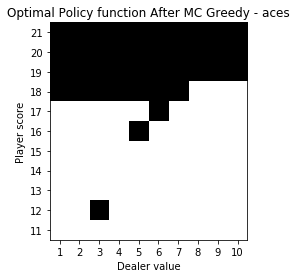

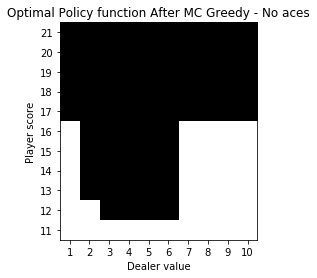

Text(0.5, 0.92, 'Value function After MC Greedy - No Aces')

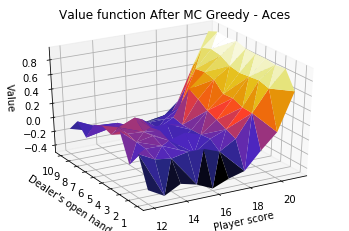

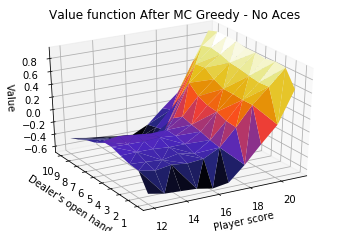

In [28]:
V_q = defaultdict(float)
for state, a in Q.items():
    q_value = np.max(a)
    V_q[state] = q_value

def plot_policy(Q, aces=True):
    # get the values for ace / non ace
    # the best action is the one with highest q value, so we take the argmax
    d = {(q[0][0], q[0][1]): np.argmax(q[1]) for q in Q.items() if q[0][2] == aces}

    # players score on x axis, dealer on y
    # players have 11 values (from 11 to 21)
    # dealer has 10 values (from A to 10)
    grid = np.ones([11, 10])
    for i in d:
        # fill the grid on the right positions
        # we do - 11 and -1 to get indices instead of actual values
        # for player it means the max value = 21 - 11 = max(index) in the grid
        # for dealer it means max value = 10 - 1 = max(index) in the grid
        grid[i[0]-11, i[1]-1] = d[i]

    fig, ax = plt.subplots()
    ax.imshow(grid, origin="lower", cmap='Greys_r')
    plt.title('Optimal Policy function After MC Greedy - {}'.format('aces' if aces else 'No aces'))  
    plt.ylabel('Player score')
    y_labels = np.arange(11, 22)
    x_labels = np.arange(1, 11)
    plt.xlabel('Dealer value')
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
    plt.show()
    

plot_policy(Q, aces=True)
plot_policy(Q, aces=False)


plot_value_function(V_q, aces=True)
plt.title('Value function After MC Greedy - Aces')  

plot_value_function(V_q, aces=False)
plt.title('Value function After MC Greedy - No Aces')  

